In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# CHEKING DISK STORAGE

In [2]:
import shutil

# Get disk space details
total, used, free = shutil.disk_usage("/")

# Convert to human-readable format
def format_size(size):
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if size < 1024:
            return f"{size:.2f} {unit}"
        size /= 1024

print(f"Total Space: {format_size(total)}")
print(f"Used Space: {format_size(used)}")
print(f"Free Space: {format_size(free)}")

Total Space: 915.32 GB
Used Space: 737.33 GB
Free Space: 131.42 GB


In [3]:
import os

def get_directory_size(directory):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(directory):
        for file in filenames:
            file_path = os.path.join(dirpath, file)
            # Add file size, skipping broken symbolic links
            if os.path.exists(file_path):
                total_size += os.path.getsize(file_path)
    return total_size

def print_directory_size(directory):
    size_bytes = get_directory_size(directory)
    # Convert bytes to a human-readable format (KB, MB, GB)
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if size_bytes < 1024:
            print(f"Size of '{directory}': {size_bytes:.2f} {unit}")
            break
        size_bytes /= 1024

# Example usage
preprocessed_files_path = "data/train_data/preprocessed_files"  # Change this to your target directory
print_directory_size(preprocessed_files_path)

preprocessed_files_path = "executions"  # Change this to your target directory
print_directory_size(preprocessed_files_path)

Size of 'data/train_data/preprocessed_files': 4.96 GB
Size of 'executions': 20.40 GB


# SETTINGS TUNING - TRAIN - TEST EXECUTION

In [4]:
############### EXECUTION SETTINGS ###############

PARENT_EXECUTION_DIR = "executions/swin_unetr/tuning-train-test"

################### DATA SETTINGS #################

DATA_DIR = "data/train_data"  
# Directory where the samples (data and labels folders) and the metadata.json file are located.

METADATA_DATASET = "metadata_6_samples.json"  
# Name of the metadata.json file located in DATA_DIR, which contains the specifications of the samples and their corresponding information used to create the dataset.

SAMPLES_PER_STRATIFIED_GROUP = None

K_FOLDS = 3
# Number of folds for the execution

NUM_WORKERS = 4
# Number of logical CPU Cores used for parallelizing data laoding

################### HYPERPARAMETER TUNING SETTINGS #################

CALLS_LIMIT_HP_TUNING = 5

# TIMEOUT_LIMIT_HP_TUNING = 60*60*24*7 # In seconds (60 sec * 60 min * 24 hours * 7 days)
TIMEOUT_LIMIT_HP_TUNING = None # In seconds (60 sec * 60 min * 24 hours * 7 days)

# CREATING EXECUTION DIRECTORY

In [5]:
import os

executions_ids = [
    int(execution_dir.split('-')[0].split('=')[1])
    for model_dir in os.listdir("executions")
    if os.path.isdir(os.path.join("executions", model_dir))  and model_dir != ".ipynb_checkpoints"
    for execution_type_dir in os.listdir(os.path.join("executions", model_dir))
    if os.path.isdir(os.path.join("executions", model_dir, execution_type_dir)) and execution_type_dir != ".ipynb_checkpoints"
    for execution_dir in os.listdir(os.path.join("executions", model_dir, execution_type_dir))
    if os.path.isdir(os.path.join("executions", model_dir, execution_type_dir, execution_dir)) and execution_dir != ".ipynb_checkpoints"
]

print(f"Total executions previously done: {len(executions_ids)}")

parent_execution_dir_path = os.path.join(PARENT_EXECUTION_DIR)

# Count the subdirectories inside parent_execution_dir_path
executions_parent_dir_count = len([
    d for d in os.listdir(parent_execution_dir_path)
    if os.path.isdir(os.path.join(parent_execution_dir_path, d)) and d != ".ipynb_checkpoints"
])

print(f"Total executions previously done ({PARENT_EXECUTION_DIR}): {executions_parent_dir_count}")

execution_id = max(executions_ids) + 1  # Assign 0 if the list is empty, otherwise the count of execution_directories
#execution_id = max(executions_ids)

print(f"Assigned execution_id: {execution_id}")

# Create a unique experiment configuration identifier
experiment_config_id = (
    f"id={execution_id}"
)

# Define and create the execution directory
execution_dir = os.path.join(parent_execution_dir_path, experiment_config_id)
os.makedirs(execution_dir, exist_ok=True)

print(f"Created execution directory: {execution_dir}")


Total executions previously done: 55
Total executions previously done (executions/swin_unetr/tuning-train-test): 45
Assigned execution_id: 176
Created execution directory: executions/swin_unetr/tuning-train-test/id=176


# DATA SPLITTING

In [6]:
import sys
import importlib

# Import the whole module 'lr_schedulers'
import utils.data_utils

# Reload the 'lr_schedulers' module
importlib.reload(utils.data_utils)

# Now, you can import the class from the reloaded module
from utils.data_utils import load_metadata, stratified_split, k_fold_stratified_split
import os

#Load metadata into a dict
metadata = load_metadata(os.path.join(DATA_DIR, METADATA_DATASET))

k_fold_splits = k_fold_stratified_split(metadata, k=K_FOLDS, n_samples_per_group = SAMPLES_PER_STRATIFIED_GROUP)

# We take the first split for defining the validation set
split_hyperparameter_tuning = k_fold_splits[0]
train_test_files, validation_files = split_hyperparameter_tuning[0], split_hyperparameter_tuning[1]
validation_files_original_copy = validation_files.copy()

# We generate the train_test splits with the rest of the data that is not used for validation
train_test_splits = k_fold_stratified_split(train_test_files, k=K_FOLDS-1)
train_test_splits_orginal_copy = train_test_splits.copy()



==================== 3-FOLD TRAINING/VALIDATION SPLIT ====================


==================== SPLIT: 0 ====================

==========> TRAINING SET

 SAMPLES: dict_keys(['R_003', 'R_004', 'Z_002', 'Z_003'])

==========> VALIDATION SET

 SAMPLES: dict_keys(['R_002', 'Z_004'])

==================== SPLIT: 1 ====================

==========> TRAINING SET

 SAMPLES: dict_keys(['R_002', 'R_004', 'Z_003', 'Z_004'])

==========> VALIDATION SET

 SAMPLES: dict_keys(['R_003', 'Z_002'])

==================== SPLIT: 2 ====================

==========> TRAINING SET

 SAMPLES: dict_keys(['R_002', 'R_003', 'Z_002', 'Z_004'])

==========> VALIDATION SET

 SAMPLES: dict_keys(['R_004', 'Z_003'])


==================== 2-FOLD TRAINING/VALIDATION SPLIT ====================


==================== SPLIT: 0 ====================

==========> TRAINING SET

 SAMPLES: dict_keys(['R_003', 'Z_003'])

==========> VALIDATION SET

 SAMPLES: dict_keys(['R_004', 'Z_002'])

==================== SPLIT: 1 =======

# GENERATING EXECUTION INFORMATION JSON

In [7]:
import json

# Define the settings as a dictionary
info_execution = {

    "INFO_EXECUTION": {
        "PARENT_EXECUTION_DIR": PARENT_EXECUTION_DIR,
        "EXECUTION_ID": execution_id,
        "EXECUTION_DIR": experiment_config_id,
        # Directory where the results of this execution will be stored.
    },
    
    "DATA_SETTINGS": {
        "DATA_DIR": DATA_DIR,
        # Directory where the samples (data and labels folders) and the metadata.json file are located.
        "METADATA_DATASET": METADATA_DATASET,
        # Name of the metadata.json file located in DATA_DIR, which contains the specifications of the samples and their corresponding information used to create the dataset.
        "K_FOLDS": K_FOLDS,
        # Number of folds for k-fold used
        "NUM_WORKERS": NUM_WORKERS, 
        # Number of logical CPU Cores used for parallelizing data laoding
        "SAMPLES_DATASET": list(metadata.keys()),
        "VALIDATION_SET": list(validation_files.keys()),
        "TRAIN_TEST_SPLITS": {},
    },

    "HYPERPARAMETER_TUNING_SETTINGS": {
        "LIMIT_TRIALS": CALLS_LIMIT_HP_TUNING,
        "TIMEOUT_LIMIT": TIMEOUT_LIMIT_HP_TUNING
    },

}

for split_idx, (train_files, test_files) in enumerate(train_test_splits):
    info_execution["DATA_SETTINGS"]["TRAIN_TEST_SPLITS"][f"SPLIT_{split_idx}"] = {}
    info_execution["DATA_SETTINGS"]["TRAIN_TEST_SPLITS"][f"SPLIT_{split_idx}"]["TRAIN_SET"] = list(train_files.keys())
    info_execution["DATA_SETTINGS"]["TRAIN_TEST_SPLITS"][f"SPLIT_{split_idx}"]["TEST_SET"] = list(test_files.keys())

info_execution_json_file_path = os.path.join(execution_dir, "info_execution.json")

# Save the dictionary as a pretty JSON file
with open(info_execution_json_file_path, "w") as json_file:
    json.dump(info_execution, json_file, indent=4)

# Print success message
print(f"Execution information JSON file successfully generated at: {info_execution_json_file_path}")

Execution information JSON file successfully generated at: executions/swin_unetr/tuning-train-test/id=176/info_execution.json


# HYPERTUNING

# Import SwinUNETR_AIRT LIGHTNING MODEL

In [8]:
import importlib
from models.swin_unetr import Swin_UNETR_AIRT_lightning_model

# Reload the module (if necessary)
importlib.reload(Swin_UNETR_AIRT_lightning_model)

# Import the class from the reloaded module
from models.swin_unetr.Swin_UNETR_AIRT_lightning_model import SwinUNETR_AIRT_LightningModel

# Import SwinUNETR_AIRT DATASET

In [9]:
import importlib
from models.swin_unetr import Swin_UNETR_AIRT_dataset

# Reload the module (if necessary)
importlib.reload(Swin_UNETR_AIRT_dataset)

# Import the class from the reloaded module
from models.swin_unetr.Swin_UNETR_AIRT_dataset import SwinUNETR_AIRT_Dataset


# HYPERTUNING

In [10]:
import optuna
import torch
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import CSVLogger
import pprint
import shutil
import gc
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import os
import time
import torchinfo
import ptflops
import random
random.seed(42)
from PIL import Image
import seaborn as sns
import numpy as np
from datetime import timedelta, datetime


import importlib
# Own library
import utils.data_utils
importlib.reload(utils.data_utils)
from utils.data_utils import custom_collate


# Function to apply the viridis colormap and convert to uint8
def apply_colormap_and_normalize(array, cmap, vmin, vmax):
    norm_array = (array - vmin) / (vmax - vmin)  # Normalize to [0, 1]
    norm_array = np.clip(norm_array, 0, 1)  # Clip values to avoid overflow
    colormap = plt.get_cmap(cmap)
    rgba_img = colormap(norm_array)  # Apply colormap, returns RGBA
    rgb_img = (rgba_img[:, :, :3] * 255).astype("uint8")  # Convert to RGB
    return rgb_img

# def objective(trial):

#     # Initialize user-defined trial attributes
#     trial.set_user_attr("model_total_params", 0)
#     trial.set_user_attr("model_trainable_params", 0)
#     trial.set_user_attr("model_non_trainable_params", 0)
#     trial.set_user_attr("model_gflops_inference", 0) 
#     trial.set_user_attr("initial_allocated_cuda_memory", 0)
#     trial.set_user_attr("initial_reserved_cuda_memory", 0)
#     trial.set_user_attr("final_allocated_cuda_memory", 0)
#     trial.set_user_attr("final_reserved_cuda_memory", 0)

#     try:

#         ########## TRAINING/INFERENCE HYPERPARAMETERS #########
    
#         lr_optimizer = trial.suggest_float("lr_optimizer", 1e-5, 1e-3, log=True)  # Log scale for learning rates
#         weight_decay_optimizer = trial.suggest_float("weight_decay_optimizer", 1e-6, 1e-2, log=True) # Log scale for weight decay
#         warmup_epochs_lr_scheduler = trial.suggest_int("warmup_epochs_lr_scheduler", 3, 10)  # Integer range
#         max_training_epochs = trial.suggest_categorical("max_training_epochs", [10000])
#         patience_epochs_early_stopping = trial.suggest_int("patience_epochs_early_stopping", 7, 20)  # Integer range
#         batch_size_training = trial.suggest_int("batch_size_training", 1, 4)
#         batch_size_inference = trial.suggest_categorical("batch_size_inference", [1]) # It doesn't matter the batch size. It always processes the patches sequentially inside the batch.
#         num_batches_grad_accumulation = trial.suggest_int("num_batches_grad_accumulation", 2, 6, step=2)
#         post_processing_strategy = trial.suggest_categorical("post_processing_strategy", ["fill_first","weighted_average"]) 
#         pre_processing_strategy = trial.suggest_categorical("pre_processing_strategy", ["uniform_gaussian_smoothed_equidistant_subsampling","hotspot_centered_gaussian_smoothed_equidistant_subsampling"])
        
#         ########## DATA PREPROCESSING HYPERPARAMETERS #########
        
#         overlap_training = trial.suggest_float("overlap_training", 0, 0.3, step = 0.15)
#         overlap_training = (overlap_training, overlap_training)
#         overlap_inference = trial.suggest_categorical("overlap_inference", ["(0,0)"])

#         ########################################################################
        
#         training_config={
#             "lr_optimizer": lr_optimizer,
#             "weight_decay_optimizer": weight_decay_optimizer,
#             "warmup_epochs_lr_scheduler": warmup_epochs_lr_scheduler,
#             "max_training_epochs": max_training_epochs,
#             "patience_epochs_early_stopping": patience_epochs_early_stopping,
#             "batch_size_training": batch_size_training,
#             "batch_size_inference": batch_size_inference,
#             "num_batches_grad_accumulation": num_batches_grad_accumulation,
#             "overlap_training": overlap_training,
#             "overlap_inference": eval(overlap_inference),
#             "post_processing_strategy": post_processing_strategy,
#             "pre_processing_strategy": pre_processing_strategy
#         }

#         ########## MODEL HYPERPARAMETERS #########

#         # Use SWIN Version 2
#         use_SWIN_v2 = trial.suggest_categorical("use_SWIN_v2", [False]) # It adds a residual convolution block at the beginning of each swin layer. (with instance normalization)
        
#         # Architecture
#         model_spatial_input_dim = trial.suggest_int("model_spatial_input_dims", 32, 192, step=32)
#         exponent_model_temporal_input_dim = trial.suggest_int("exponent_model_temporal_input_dim", 0, 3)
#         model_temporal_input_dim = 64*(2**exponent_model_temporal_input_dim)
#         model_input_dimensions = (model_spatial_input_dim, model_spatial_input_dim) + (model_temporal_input_dim,)
#         exponent_initial_feature_embedding_size = trial.suggest_int("exponent_initial_feature_embedding_size", 0, 3)
#         initial_feature_embedding_size = 12*(2**exponent_initial_feature_embedding_size)
#         patch_embedding_size = trial.suggest_categorical("patch_embedding_size", [2])
#         num_swin_transformer_blocks_in_layers = trial.suggest_categorical("num_swin_transformer_blocks_in_layers", [2])
#         multilayer_perceptron_expansion_ratio_transformer_block=trial.suggest_categorical("mlp_ratio", [4.0]) # Defines the expansion of the MLP's hidden dimension relative to its input dimension

#         # Attention
#         initial_attention_head = trial.suggest_int("initial_attention_head", 2, 3, step=1)
#         attention_heads = (initial_attention_head, initial_attention_head*2, initial_attention_head*4, initial_attention_head*8)
#         attention_window_size = trial.suggest_int("attention_window_size", 7, 8, step=1)
#         attention_qkv_bias_projections = trial.suggest_categorical("attention_qkv_projections_bias", [True])
#         attention_weights_drop_rate =  trial.suggest_categorical("attention_weights_drop_rate", [0]) #[0, 0.1, 0.2]

#         # Normalization
#         layer_normalization_after_each_layer_in_SWIN_Transformer = trial.suggest_categorical("layer_normalization_after_each_layer_in_SWIN_Transformer", [True])
#         type_normalization_in_UNET_block = trial.suggest_categorical("type_normalization_in_UNET_block", ["instance"])
#         normalization_after_patch_embedding = trial.suggest_categorical("normalization_after_patch_embedding", [False])

#         # Regularization
#         transformer_block_drop_rate = trial.suggest_categorical("transformer_block_drop_rate", [0]) #[0, 0.1, 0.3]
#         transformer_block_residual_block_dropout_path_rate = trial.suggest_categorical("transformer_block_residual_block_dropout_path_rate", [0]) #[0, 0.1, 0.2]

#         # Architecture Configuration
#         architecture_config={
#             "use_SWIN_v2": use_SWIN_v2,
#             "model_input_dimensions": model_input_dimensions,
#             "model_input_channels": 1,
#             "model_output_channels": 2, # 2 output channels = 2 output classes (i.e. defective/non-defective)
#             "initial_feature_embedding_size": initial_feature_embedding_size,
#             "patch_embedding_size": (patch_embedding_size, patch_embedding_size, patch_embedding_size),
#             "num_swin_transformer_blocks_in_layers": (num_swin_transformer_blocks_in_layers, num_swin_transformer_blocks_in_layers, num_swin_transformer_blocks_in_layers, num_swin_transformer_blocks_in_layers),
#             "mlp_ratio": multilayer_perceptron_expansion_ratio_transformer_block,
#         }
        
#         # Attention Configuration
#         attention_config={
#             "heads": attention_heads,
#             "window_size": (attention_window_size, attention_window_size, attention_window_size),
#             "qkv_bias": attention_qkv_bias_projections,
#             "drop_rate": attention_weights_drop_rate,
#         }
        
#         # Normalization Configuration
#         normalization_config={
#             "use_norm_in_swinViT_after_layer": layer_normalization_after_each_layer_in_SWIN_Transformer,
#             "patch_norm_in_swinViT": normalization_after_patch_embedding,
#             "unet_block_norm_type": type_normalization_in_UNET_block
#         }
        
#         # Regularization Configuration
#         regularization_config={
#             "transformer_block_drop_rate": transformer_block_drop_rate,
#             "transformer_block_residual_block_dropout_path_rate": transformer_block_residual_block_dropout_path_rate,
#         }

#         # Combine all configs into a single dictionary
#         trial_config = {
#             "TRAINING_CONFIG": training_config,
#             "ARCHITECTURE_CONFIG": architecture_config,
#             "ATTENTION_CONFIG": attention_config,
#             "NORMALIZATION_CONFIG": normalization_config,
#             "REGULARIZATION_CONFIG": regularization_config,
#         }

#         print()
#         print(f"{'=' * 50}")
#         print(f"{'=' * 16} RUNNING TRIAL: {trial.number} {'=' * 16}")
#         print(f"{'=' * 16} Time: {datetime.now()} {'=' * 16}")
#         print(f"{'=' * 50}")
#         print()
        
#         # Pretty-print the configurations
#         pprint.pprint(trial_config, sort_dicts=False, width=100)

#         print()

#         # Log CUDA memory at the start of the trial
#         if torch.cuda.is_available():
#             trial.set_user_attr("initial_allocated_cuda_memory", torch.cuda.memory_allocated() / 1e6)
#             trial.set_user_attr("initial_reserved_cuda_memory", torch.cuda.memory_reserved() / 1e6)
#             trial.set_user_attr("final_allocated_cuda_memory", 0)
#             trial.set_user_attr("final_reserved_cuda_memory", 0)
        
#         ########## DATA PREPARATION #########

#         # Creation Datasets 
#         train_dataset = SwinUNETR_AIRT_Dataset(
#             is_inference_mode = False,
#             augmentation = True,
#             metadata_dict_with_files_selected=train_test_files.copy(),
#             data_dir=DATA_DIR,
#             model_input_dims=model_input_dimensions,
#             overlap = overlap_training,
#             preprocessing_strategy = pre_processing_strategy
#         )

#         val_dataset = SwinUNETR_AIRT_Dataset(
#             is_inference_mode = True,
#             augmentation = True,
#             metadata_dict_with_files_selected=validation_files.copy(),
#             data_dir=DATA_DIR,
#             model_input_dims=model_input_dimensions,
#             overlap = eval(overlap_inference),
#             preprocessing_strategy = pre_processing_strategy
#         )

#         # Configure DataLoaders
#         train_loader = DataLoader(train_dataset, batch_size=batch_size_training, shuffle=True, num_workers=NUM_WORKERS)
#         val_loader = DataLoader(val_dataset, batch_size=batch_size_inference, collate_fn=custom_collate, num_workers=NUM_WORKERS)
        
#         ########## MODEL INSTANTIATION #########
        
#         model = SwinUNETR_AIRT_LightningModel(
#             # Training Configuration
#             training_config=training_config,            
#             # Architecture Configuration
#             architecture_config=architecture_config,            
#             # Attention Configuration
#             attention_config=attention_config,
#             # Normalization Configuration
#             normalization_config=normalization_config,         
#             # Regularization Configuration
#             regularization_config=regularization_config
#         )

#         ########## TRAINER INSTANTIATION #########

#         # Early stopping callback
#         early_stopping_callback = EarlyStopping(
#             monitor='val_loss',
#             patience=patience_epochs_early_stopping,
#             mode='min'
#         )

#         # Define logger
#         logger = CSVLogger(
#             save_dir=tuning_dir,
#             name="",
#             version="")
        
#         trainer = Trainer(
#             max_epochs=max_training_epochs,
#             callbacks=[early_stopping_callback],
#             precision="16-mixed",  # Enable FP16 mixed precision
#             accumulate_grad_batches=num_batches_grad_accumulation,
#             enable_checkpointing=False,
#             log_every_n_steps=1,
#             logger=logger,
#             enable_progress_bar=False,
#             # Add timeout for this trial
#             max_time="00:00:02:00"  # Limit TIME (DD:HH:MM:SS format)
#         )

#         ########## TRAINING #########

#         # Train the model
#         trainer.fit(model, train_loader, val_loader)

#         input_size = (batch_size_inference, 1, model_input_dimensions[0], model_input_dimensions[1],model_input_dimensions[2])

#         ### Get Total, Trainable, Non-Trainable Parameters
#         model_summary = torchinfo.summary(model.model, input_size=input_size, verbose=0)

#         # Store parameters in variables
#         total_params = model_summary.total_params
#         trainable_params = model_summary.trainable_params
#         non_trainable_params = total_params - trainable_params

#         ### Get FLOPs (Floating Point Operations)
#         # Input size for ptflops is without batch size: (channels, height, width)
#         macs, params = ptflops.get_model_complexity_info(model.model, input_size[1:], as_strings=False, verbose=False)
#         # FLOPs are twice the MACs (Multiply-Accumulate Operations)
#         if macs is None:
#             raise torch.cuda.OutOfMemoryError()
            
#         flops = 2 * macs

#         trial.set_user_attr("model_total_params", total_params)
#         trial.set_user_attr("model_trainable_params", trainable_params)
#         trial.set_user_attr("model_non_trainable_params", non_trainable_params)
#         trial.set_user_attr("model_gflops_inference", flops / 1e9) # Convert FLOPs to GFLOPs

#         print()
#         print(f"Total Parameters: {total_params}")
#         print(f"Trainable Parameters: {trainable_params}")
#         print(f"Non-Trainable Parameters: {non_trainable_params}")
#         print(f"FLOPs: {flops / 1e9:.3f} GFLOPs")

#         # Retrieve the best validation loss
#         metrics_file = os.path.join(tuning_dir, 'metrics.csv')
#         metrics_df = pd.read_csv(metrics_file)
        
#         # Initialize variables to make them accessible outside the if scope
#         lowest_val_loss = None
#         lowest_epoch = None

#         # Ensure val_loss column exists and drop NaN values
#         if 'val_loss_epoch' in metrics_df.columns:
#             val_loss_series = metrics_df['val_loss_epoch'].dropna()
#             # Find the lowest val_loss
#             lowest_val_loss = val_loss_series.min()
#             # Find the epoch corresponding to the lowest val_loss
#             lowest_val_loss_row = metrics_df.loc[val_loss_series.idxmin()]
#             lowest_epoch = lowest_val_loss_row['epoch']
        
#             print(f"Lowest val_loss: {lowest_val_loss} at epoch {lowest_epoch}")
#         else:
#             print(f"val_loss column not found in {metrics_file}")

#         ######### PLOTTING ##########

#         ##### PLOT BEST VAL RESULTS #####

#         print()
#         print(f"{'=' * 10} PLOTTING BEST EPOCH VALIDATION RESULTS {'=' * 10}")
#         print()

#         # Control the maximum number of samples to show
#         num_samples_to_show = 9
        
#         # Adjust the number of samples if fewer samples are available
#         available_samples = list(zip(
#             model.best_epoch_val_sample_ids,
#             model.best_epoch_val_ground_truths,
#             model.best_epoch_val_predictions
#         ))
        
#         if len(available_samples) < num_samples_to_show:
#             print(f"Number of available samples ({len(available_samples)}) is less than requested ({num_samples_to_show}). Plotting all available samples.")
#             num_samples_to_show = len(available_samples)
        
#         # Randomly sample the data if more samples are available than requested
#         plot_samples = random.sample(available_samples, num_samples_to_show)
        
#         # Calculate the number of rows needed (3 pairs per row)
#         pairs_per_row = 3
#         num_rows = (num_samples_to_show + pairs_per_row - 1) // pairs_per_row  # Ceiling division

#         # Find unique classes dynamically
#         all_classes = set()
#         for gt, pred in zip(model.best_epoch_val_ground_truths, model.best_epoch_val_predictions):
#             all_classes.update(torch.unique(gt).tolist())  # Add classes from ground truth
#             all_classes.update(torch.unique(pred).tolist())  # Add classes from predictions
        
#         # Sort the classes to ensure order
#         all_classes = sorted(all_classes)
        
#         # Define class labels dynamically (for simplicity, use numeric labels for now)
#         class_labels = {cls: f"Class {cls}" for cls in all_classes}
#         num_classes = len(class_labels)
        
#         # Create a discrete colormap with exactly `num_classes` colors
#         colormap = plt.cm.get_cmap("viridis", num_classes)
        
#         # Create legend patches using discrete colors from the colormap
#         legend_patches = [
#             mpatches.Patch(color=colormap(i), label=f"{i}: {label}")
#             for i, label in class_labels.items()
#         ]
#         # Create subplots
#         fig, axes = plt.subplots(num_rows, pairs_per_row * 2, figsize=(15, 5 * num_rows))
        
#         # If there's only one row, ensure axes is 2D
#         if num_rows == 1:
#             axes = [axes]
        
#         # Flatten axes for easier indexing
#         axes = [ax for row_axes in axes for ax in (row_axes if isinstance(row_axes, (list, np.ndarray)) else [row_axes])]
        
#         # Plot ground truth and predictions
#         for idx, (sample_id, ground_truth, prediction) in enumerate(plot_samples):
#             # Calculate column index (each pair takes two columns)
#             col_idx = idx * 2
        
#             # Ground truth
#             axes[col_idx].imshow(ground_truth.cpu().numpy(), cmap="viridis", interpolation="none",
#                                  vmin=min(all_classes), vmax=max(all_classes))
#             axes[col_idx].set_title(f"Sample {sample_id}\n Ground Truth \n [{ground_truth.shape[0]} x {ground_truth.shape[1]}]")
#             axes[col_idx].axis("off")
        
#             # Prediction
#             axes[col_idx + 1].imshow(prediction.cpu().numpy(), cmap="viridis", interpolation="none",
#                                      vmin=min(all_classes), vmax=max(all_classes))
#             axes[col_idx + 1].set_title(f"Sample {sample_id}\n Prediction \n [{prediction.shape[0]} x {prediction.shape[1]}]")
#             axes[col_idx + 1].axis("off")
        
#         # Hide any unused subplots
#         for unused_ax in axes[len(plot_samples) * 2:]:
#             unused_ax.axis("off")
        
#         # Add legend
#         fig.legend(
#             handles=legend_patches,
#             loc="upper center",  # Places the legend below the plot
#             ncol=len(all_classes),
#             bbox_to_anchor=(0.5, 0.9),  # Adjusts position below the plot
#             fontsize=12
#         )
        
#         # Add title
#         fig.suptitle(
#             f"Trial {trial.number}\nGround Truth vs Prediction\n"
#             f"Lowest Val Loss: {lowest_val_loss:.4f} - Lowest Epoch: {lowest_epoch}",
#             fontsize=16, y=1.10
#         )
        
        
#         plt.tight_layout(rect=[0, 0, 1, 0.85])
#         plt.show()
#         plt.close(fig)

#         ##### PLOT TRAINING & VALIDATION LOSSES EVOLUTION ##### 

#         print()
#         print(f"{'=' * 10} PLOTTING TRAINING & VALIDATION LOSSES EVOLUTION {'=' * 10}")
#         print()
        
#         # Path to the latest metrics file
#         metrics_file = os.path.join(tuning_dir, 'metrics.csv')
#         metrics_df = pd.read_csv(metrics_file)
        
#         # Handle train_loss and val_loss separately
#         train_loss = metrics_df[['epoch', 'train_loss_epoch']].dropna().rename(columns={'train_loss_epoch': 'loss'})
#         train_loss['type'] = 'Training Loss'
        
#         val_loss = metrics_df[['epoch', 'val_loss_epoch']].dropna().rename(columns={'val_loss_epoch': 'loss'})
#         val_loss['type'] = 'Validation Loss'
        
#         # Combine the two datasets for seaborn
#         plot_data = pd.concat([train_loss, val_loss], axis=0)
        
#         # Plot using seaborn
#         plt.figure(figsize=(12, 8))
#         sns.lineplot(data=plot_data, x='epoch', y='loss', hue='type', marker="o", style="type", dashes=False)
#         plt.xlabel("Epoch")
#         plt.ylabel("Loss")
#         plt.title("Training and Validation Loss Over Epochs")
#         plt.grid(True)
#         plt.legend(title="Loss Type")
#         plt.show()

#         # Directory to save individual SVG images
#         best_trial_dir = os.path.join(tuning_dir, "best_trial")
#         os.makedirs(best_trial_dir, exist_ok=True)  # Create the folder if it doesn't exist

#         if hasattr(trial, "study"):
#             completed_trials = [t for t in trial.study.trials if t.state == optuna.trial.TrialState.COMPLETE]
#         else: # It is initial fixed trial
#             completed_trials = []

#         if len(completed_trials) == 0:
#              best_trial_value_study = float('inf')
#         else:
#              best_trial_value_study = trial.study.best_trial.value

#         if len(completed_trials) == 0 or best_trial_value_study > lowest_val_loss:

#             ##### SAVING PLOT BEST TRIAL TRAINING/VALIDATION LOSS EVOLUTION ##### 

#             # Path to the latest metrics file
#             metrics_file = os.path.join(tuning_dir, 'metrics.csv')
#             metrics_df = pd.read_csv(metrics_file)
            
#             # Handle train_loss and val_loss separately
#             train_loss = metrics_df[['epoch', 'train_loss_epoch']].dropna().rename(columns={'train_loss_epoch': 'loss'})
#             train_loss['type'] = 'Training Loss'
            
#             val_loss = metrics_df[['epoch', 'val_loss_epoch']].dropna().rename(columns={'val_loss_epoch': 'loss'})
#             val_loss['type'] = 'Validation Loss'
            
#             # Combine the two datasets for seaborn
#             plot_data = pd.concat([train_loss, val_loss], axis=0)
            
#             # Plot using seaborn
#             fig = plt.figure(figsize=(12, 8))
#             sns.lineplot(data=plot_data, x='epoch', y='loss', hue='type', marker="o", style="type", dashes=False)
#             plt.xlabel("Epoch")
#             plt.ylabel("Loss")
#             plt.title("Training and Validation Loss Over Epochs")
#             plt.grid(True)
#             plt.legend(title="Loss Type")

#             # Save as SVG
#             plt.tight_layout()
#             result_plot_path = os.path.join(best_trial_dir, f"train_val_loss_evolution.svg")
#             fig.savefig(result_plot_path, format="svg", bbox_inches="tight")
#             print(f"Best Trial Training/Vlaidation Loss Evolution plot saved at: {result_plot_path}")
#             plt.close(fig)
            
#             ##### SAVING PLOT BEST TRIAL VALIDATION RESULTS #####            
            
#             # Control the maximum number of samples to show
#             num_samples_to_show = 9
            
#             # Adjust the number of samples if fewer samples are available
#             available_samples = list(zip(
#                 model.best_epoch_val_sample_ids,
#                 model.best_epoch_val_ground_truths,
#                 model.best_epoch_val_predictions
#             ))
            
#             if len(available_samples) < num_samples_to_show:
#                 print(f"Number of available samples ({len(available_samples)}) is less than requested ({num_samples_to_show}). Plotting all available samples.")
#                 num_samples_to_show = len(available_samples)
            
#             # Randomly sample the data if more samples are available than requested
#             plot_samples = random.sample(available_samples, num_samples_to_show)
            
#             # Calculate the number of rows needed (3 pairs per row)
#             pairs_per_row = 3
#             num_rows = (num_samples_to_show + pairs_per_row - 1) // pairs_per_row  # Ceiling division

#             # Find unique classes dynamically
#             all_classes = set()
#             for gt, pred in zip(model.best_epoch_val_ground_truths, model.best_epoch_val_predictions):
#                 all_classes.update(torch.unique(gt).tolist())  # Add classes from ground truth
#                 all_classes.update(torch.unique(pred).tolist())  # Add classes from predictions
            
#             # Sort the classes to ensure order
#             all_classes = sorted(all_classes)
            
#             # Define class labels dynamically (for simplicity, use numeric labels for now)
#             class_labels = {cls: f"Class {cls}" for cls in all_classes}
#             num_classes = len(class_labels)
            
#             # Create a discrete colormap with exactly `num_classes` colors
#             colormap = plt.cm.get_cmap("viridis", num_classes)
            
#             # Create legend patches using discrete colors from the colormap
#             legend_patches = [
#                 mpatches.Patch(color=colormap(i), label=f"{i}: {label}")
#                 for i, label in class_labels.items()
#             ]
            
#             # Create subplots
#             fig, axes = plt.subplots(num_rows, pairs_per_row * 2, figsize=(15, 5 * num_rows))
            
#             # If there's only one row, ensure axes is 2D
#             if num_rows == 1:
#                 axes = [axes]
            
#             # Flatten axes for easier indexing
#             axes = [ax for row_axes in axes for ax in (row_axes if isinstance(row_axes, (list, np.ndarray)) else [row_axes])]
            
#             # Plot ground truth and predictions
#             for idx, (sample_id, ground_truth, prediction) in enumerate(plot_samples):
#                 # Calculate column index (each pair takes two columns)
#                 col_idx = idx * 2
            
#                 # Ground truth
#                 axes[col_idx].imshow(ground_truth.cpu().numpy(), cmap="viridis", interpolation="none",
#                                      vmin=min(all_classes), vmax=max(all_classes))
#                 axes[col_idx].set_title(f"Sample {sample_id}\n Ground Truth \n [{ground_truth.shape[0]} x {ground_truth.shape[1]}]")
#                 axes[col_idx].axis("off")

#                 # Saving ground truth image
#                 ground_truth_data = ground_truth.cpu().numpy()  # Convert to NumPy array
#                 ground_truth_colored = apply_colormap_and_normalize(
#                     ground_truth_data, cmap="viridis", vmin=min(all_classes), vmax=max(all_classes)
#                 )
#                 ground_truth_img = Image.fromarray(ground_truth_colored)  # Convert to Pillow Image
#                 ground_truth_img.save(os.path.join(best_trial_dir, f"{sample_id}_gt.png"))
            
#                 # Prediction
#                 axes[col_idx + 1].imshow(prediction.cpu().numpy(), cmap="viridis", interpolation="none",
#                                          vmin=min(all_classes), vmax=max(all_classes))
#                 axes[col_idx + 1].set_title(f"Sample {sample_id}\n Prediction \n [{prediction.shape[0]} x {prediction.shape[1]}]")
#                 axes[col_idx + 1].axis("off")

#                 # Saving prediction image
#                 prediction_data = prediction.cpu().numpy()  # Convert to NumPy array
#                 prediction_colored = apply_colormap_and_normalize(
#                     prediction_data, cmap="viridis", vmin=min(all_classes), vmax=max(all_classes)
#                 )
#                 prediction_img = Image.fromarray(prediction_colored)  # Convert to Pillow Image
#                 prediction_img.save(os.path.join(best_trial_dir, f"{sample_id}_pred.png"))
            
#             # Hide any unused subplots
#             for unused_ax in axes[len(plot_samples) * 2:]:
#                 unused_ax.axis("off")
            
#             # Add legend
#             fig.legend(
#                 handles=legend_patches,
#                 loc="upper center",  # Places the legend below the plot
#                 ncol=len(all_classes),
#                 bbox_to_anchor=(0.5, 0.9),  # Adjusts position below the plot
#                 fontsize=12
#             )
            
#             # Add title
#             fig.suptitle(
#                 f"Trial {trial.number}\nGround Truth vs Prediction\n"
#                 f"Lowest Val Loss: {lowest_val_loss:.4f} - Lowest Epoch: {lowest_epoch}",
#                 fontsize=16, y=1.10
#             )
            
#             # Save as SVG
#             plt.tight_layout(rect=[0, 0, 1, 0.85])
#             result_plot_path = os.path.join(best_trial_dir, f"validation_gt_vs_pred.svg")
#             fig.savefig(result_plot_path, format="svg", bbox_inches="tight")
#             print(f"Validation results plot saved at: {result_plot_path}")
#             plt.close(fig)



#         # Log CUDA memory at the start of the trial
#         if torch.cuda.is_available():
#             trial.set_user_attr("final_allocated_cuda_memory", torch.cuda.memory_allocated() / 1e6)
#             trial.set_user_attr("final_reserved_cuda_memory", torch.cuda.memory_reserved() / 1e6)   
    
#         del model
#         del trainer
#         gc.collect()
#         torch.cuda.empty_cache()
        
        
#         return lowest_val_loss

#     except torch.cuda.OutOfMemoryError:
#         # Log CUDA memory at the start of the trial
#         if torch.cuda.is_available():
#             trial.set_user_attr("final_allocated_cuda_memory", torch.cuda.memory_allocated() / 1e6)
#             trial.set_user_attr("final_reserved_cuda_memory", torch.cuda.memory_reserved() / 1e6)   # Convert to MB
#         try:
#             del model
#         except UnboundLocalError:
#             pass  # Model was never created, so no need to delete it
            
#         try:
#             del trainer
#         except UnboundLocalError:
#             pass  # Trainer was never created, so no need to delete it
            
#         gc.collect()
#         torch.cuda.empty_cache()
#         print()
#         print(f"{'=' * 50}")
#         print(f"{'=' * 14} TRIAL {trial.number} SKIPPED - CUDA OUT OF MEMORY ERROR {'=' * 14}")
#         print(f"{'=' * 50}")
#         print()
#         trial.report(float('inf'), step=0)  # Assign a penalty
#         # time.sleep(60) # Allow time for the CUDA memory to be released
#         raise optuna.exceptions.TrialPruned()

In [11]:
# #Loading manually initial trial
# initial_trial_param_values = {
#                         "lr_optimizer": 5e-5,
#                         "weight_decay_optimizer": 2e-6,
#                         "warmup_epochs_lr_scheduler": 7,
#                         "max_training_epochs": 10000,
#                         "patience_epochs_early_stopping": 15,
#                         "batch_size_training": 1,
#                         "batch_size_inference": 1,
#                         "num_batches_grad_accumulation": 2,
#                         "post_processing_strategy": "weighted_average",
#                         "pre_processing_strategy": "uniform_gaussian_smoothed_equidistant_subsampling",
#                         "overlap_training": 0,
#                         "overlap_inference": "(0,0)",
#                         "use_SWIN_v2": False,
#                         "model_spatial_input_dims": 192,
#                         "exponent_model_temporal_input_dim": 0,
#                         "exponent_initial_feature_embedding_size": 0,
#                         "patch_embedding_size": 2,
#                         "num_swin_transformer_blocks_in_layers": 2,
#                         "mlp_ratio": 4.0,
#                         "initial_attention_head": 2,
#                         "attention_window_size": 7,
#                         "attention_qkv_projections_bias": True,
#                         "attention_weights_drop_rate": 0,
#                         "layer_normalization_after_each_layer_in_SWIN_Transformer": True,
#                         "type_normalization_in_UNET_block": "instance",
#                         "normalization_after_patch_embedding": False,
#                         "transformer_block_drop_rate": 0,
#                         "transformer_block_residual_block_dropout_path_rate": 0 
# }

# # Define search space
# search_space = {
#     "lr_optimizer": optuna.distributions.FloatDistribution(1e-5, 1e-3, log=True),
#     "weight_decay_optimizer": optuna.distributions.FloatDistribution(1e-6, 1e-2, log=True),
#     "warmup_epochs_lr_scheduler": optuna.distributions.IntDistribution(3, 10),
#     "max_training_epochs": optuna.distributions.CategoricalDistribution([10000]),
#     "patience_epochs_early_stopping": optuna.distributions.IntDistribution(7, 20),
#     "batch_size_training": optuna.distributions.IntDistribution(1, 4),
#     "batch_size_inference": optuna.distributions.CategoricalDistribution([1]),
#     "num_batches_grad_accumulation": optuna.distributions.IntDistribution(2, 6, step=2),
#     "post_processing_strategy": optuna.distributions.CategoricalDistribution(["fill_first", "weighted_average"]),
#     "pre_processing_strategy": optuna.distributions.CategoricalDistribution([
#         "uniform_gaussian_smoothed_equidistant_subsampling",
#         "hotspot_centered_gaussian_smoothed_equidistant_subsampling"
#     ]),
#     "overlap_training": optuna.distributions.FloatDistribution(0, 0.3, step=0.15),
#     "overlap_inference": optuna.distributions.CategoricalDistribution(["(0,0)"]),
#     "use_SWIN_v2": optuna.distributions.CategoricalDistribution([False]),
#     "model_spatial_input_dims": optuna.distributions.IntDistribution(32, 192, step=32),
#     "exponent_model_temporal_input_dim": optuna.distributions.IntDistribution(0, 3),
#     "exponent_initial_feature_embedding_size": optuna.distributions.IntDistribution(0, 3),
#     "patch_embedding_size": optuna.distributions.CategoricalDistribution([2]),
#     "num_swin_transformer_blocks_in_layers": optuna.distributions.CategoricalDistribution([2]),
#     "mlp_ratio": optuna.distributions.CategoricalDistribution([4.0]),
#     "initial_attention_head": optuna.distributions.IntDistribution(2, 3, step=1),
#     "attention_window_size": optuna.distributions.IntDistribution(7, 8, step=1),
#     "attention_qkv_projections_bias": optuna.distributions.CategoricalDistribution([True]),
#     "attention_weights_drop_rate": optuna.distributions.CategoricalDistribution([0]),
#     "layer_normalization_after_each_layer_in_SWIN_Transformer": optuna.distributions.CategoricalDistribution([True]),
#     "type_normalization_in_UNET_block": optuna.distributions.CategoricalDistribution(["instance"]),
#     "normalization_after_patch_embedding": optuna.distributions.CategoricalDistribution([False]),
#     "transformer_block_drop_rate": optuna.distributions.CategoricalDistribution([0]),
#     "transformer_block_residual_block_dropout_path_rate": optuna.distributions.CategoricalDistribution([0]),
# }

In [ ]:
from datetime import datetime
import json
import subprocess

start_time = datetime.now()
print("Hyperparameter Tuning execution started at:", start_time)
print()

# Create the directory
tuning_dir = os.path.join(execution_dir, 'tuning')
os.makedirs(tuning_dir)  # `exist_ok=True` prevents error if the directory already exists
print(f"Tuning directory created: {tuning_dir}")

study_storage_path = os.path.join("sqlite:///", tuning_dir, f"optuna_study.db")

# sampler = optuna.samplers.TPESampler(multivariate=True)

study_name=f"study_id={execution_id}"

# study = optuna.create_study(
#     study_name=study_name, 
#     direction="minimize", 
#     storage=study_storage_path, 
#     sampler=optuna.samplers.TPESampler(multivariate=True),
#     load_if_exists=True
# )

# # ✅ Step 2: Manually create a trial with predefined hyperparameters
# trial = study.ask(fixed_distributions=search_space)  # Create a new trial using the search space

# # ✅ Step 3: Set fixed hyperparameters
# for param, value in initial_trial_param_values.items():
#     trial.set_user_attr(param, value)  # Store them as user attributes
#     if isinstance(search_space[param], optuna.distributions.FloatDistribution):
#         trial.suggest_float(param, value, value)  # Fix float values
#     elif isinstance(search_space[param], optuna.distributions.IntDistribution):
#         trial.suggest_int(param, value, value)  # Fix integer values
#     elif isinstance(search_space[param], optuna.distributions.CategoricalDistribution):
#         trial.suggest_categorical(param, [value])  # Fix categorical values

# # ✅ Step 4: Evaluate the objective function
# fixed_trial_value = objective(trial)  # Run the objective function for the fixed trial

# # ✅ Step 5: Mark the trial as complete
# study.tell(trial, fixed_trial_value)  # Store the trial results in the study

# print(f"✅ Initial fixed trial completed with value: {fixed_trial_value}")

# Ejecutar la optimización con Optuna
# study = optuna.create_study(study_name=study_name, direction="minimize", storage=study_storage_path, sampler=sampler)

# # Run first trial manually
# first_trial = objective(optuna.trial.FixedTrial(initial_trial_param_values))

# study.add_trial(optuna.trial.create_trial(
#     params=initial_trial_param_values,
#     distributions=search_space,
#     value=first_trial
# ))

# Create the tempory directory, and ignore if it already exists
os.makedirs(os.path.join(tuning_dir, "temporary_files"), exist_ok=True)

# Save JSON data to temporary files
train_test_files_path = os.path.join(tuning_dir, "temporary_files", "train_test_files.json")
validation_files_path = os.path.join(tuning_dir, "temporary_files", "validation_files.json")

with open(train_test_files_path, 'w') as f:
    json.dump(train_test_files, f)
    
with open(validation_files_path, 'w') as f:
    json.dump(validation_files, f)

if CALLS_LIMIT_HP_TUNING is not None and TIMEOUT_LIMIT_HP_TUNING is None:
    study.set_user_attr("study_n_trials_limit", CALLS_LIMIT_HP_TUNING)
    for trial_idx in range(CALLS_LIMIT_HP_TUNING):
        print(f"Starting trial #{trial_idx} in a separate process...")
        process = subprocess.Popen(
            [
                "python", "-u", "run_SWIN_trial.py", study_name, study_storage_path, DATA_DIR, tuning_dir, str(NUM_WORKERS)
            ],
            stdout=subprocess.PIPE,  # Capture stdout
            stderr=subprocess.PIPE,  # Capture stderr
            text=True,
            bufsize=1,  # Line buffering
            universal_newlines=True
        )
        
        # Stream output to Jupyter Notebook in real-time
        for line in iter(process.stdout.readline, ''):
            print(line, end='')  # Print each line immediately
            sys.stdout.flush()   # Ensure it appears in the notebook
        
        # Wait for process to complete
        process.wait()
    
        print(f"Trial #{trial_idx} completed. GPU memory should be freed.\n")
    
elif TIMEOUT_LIMIT_HP_TUNING is not None and CALLS_LIMIT_HP_TUNING is None:
    study.set_user_attr("study_timeout_limit", CALLS_LIMIT_HP_TUNING)
    # Start timer
    start_time = datetime.now()
    
    trial_idx = 0  # Keep track of trial numbers
    
    while (datetime.now() - start_time).total_seconds() < TIMEOUT_LIMIT_HP_TUNING:
        print(f"Starting trial #{trial_idx} in a separate process...")
        
        process = subprocess.Popen(
            [
                "python", "-u", "run_SWIN_trial.py", study_name, study_storage_path, DATA_DIR, tuning_dir, str(NUM_WORKERS)
            ],
            stdout=subprocess.PIPE,  # Capture stdout
            stderr=subprocess.PIPE,  # Capture stderr
            text=True,
            bufsize=1,  # Line buffering
            universal_newlines=True
        )
        
        # Check if timeout is exceeded while process is running
        while process.poll() is None:  # process.poll() returns None if process is still running
            elapsed_time = (datetime.now() - start_time).total_seconds()
            
            if elapsed_time >= TIMEOUT_LIMIT_HP_TUNING:
                print(f"Timeout exceeded after {elapsed_time:.2f} seconds. Terminating trial #{trial_idx}...")
                
                # Terminate process gracefully
                process.terminate()  # Sends SIGTERM
                
                # If process is still running, force kill it
                time.sleep(5)  # Give some time to terminate gracefully
                if process.poll() is None:
                    print("Process did not terminate in time. Force killing it now.")
                    process.kill()  # Sends SIGKILL
                
                break  # Exit loop after timeout
            
            time.sleep(1)  # Avoid excessive CPU usage in the loop
        
        # Ensure process is completed or terminated before proceeding
        process.wait()
        
        print(f"Trial #{trial_idx} completed. GPU memory should be freed.\n")
    
        trial_idx += 1  # Increment trial counter
else:
    raise ValueError("Exactly one of CALLS_LIMIT_HP_TUNING or TIMEOUT_LIMIT_HP_TUNING must be set to None.")

# Check if the temporary folder exists before attempting deletion
if os.path.exists(os.path.join(tuning_dir, "temporary_files")):
    shutil.rmtree(os.path.join(tuning_dir, "temporary_files"))  # Deletes the folder and all its contents
    print(f"Deleted folder: {os.path.join(tuning_dir, 'temporary_files')}")
else:
    print(f"Folder does not exist: {os.path.join(tuning_dir, 'temporary_files')}")


print()
end_time = datetime.now()
print("Hyperparameter Tuning execution ended at:", end_time)
print()

# Compute the total execution time
execution_time = end_time - start_time
print(f"Total Hyperparameter Tuning execution time: {execution_time}")

# RESUME STUDY

In [13]:
# print(f"(Before releasing CUDA memory) Allocated CUDA memory: {torch.cuda.memory_allocated() / 1e6:.2f} MB")
# print(f"(Before releasing CUDA memory) Reserved CUDA memory: {torch.cuda.memory_reserved() / 1e6:.2f} MB")

# del study
# gc.collect()
# torch.cuda.empty_cache()


# time.sleep(240) 

print(f"(After releasing CUDA memory) Allocated CUDA memory: {torch.cuda.memory_allocated() / 1e6:.2f} MB")
print(f"(After releasing CUDA memory) Reserved CUDA memory: {torch.cuda.memory_reserved() / 1e6:.2f} MB")

# Create the directory
tuning_dir = os.path.join(execution_dir, 'tuning')
print(f"Tuning directory: {tuning_dir}")

study_storage_path = os.path.join("sqlite:///", tuning_dir, f"optuna_study.db")

# OR load an existing study
study = optuna.load_study(study_name=f"study_id={execution_id}", storage=study_storage_path)

# n_trials_specified_to_try = study.user_attrs["n_trials_specified_to_try"]
# already_tried_trials = len(study.trials)

# print(f"Number of trials specified to try: {n_trials_specified_to_try}")
# print(f"Number of trials already tried: {already_tried_trials}")

# study.optimize(objective, n_trials=n_trials_specified_to_try-already_tried_trials)

(After releasing CUDA memory) Allocated CUDA memory: 0.00 MB
(After releasing CUDA memory) Reserved CUDA memory: 0.00 MB
Tuning directory: executions/swin_unetr/tuning-train-test/id=176/tuning


# INFO HYPERPARAMETER TUNING

In [14]:
import os
import plotly.io as pio

# Set default renderer for Jupyter Notebook/Lab
pio.renderers.default = 'iframe'

# Visualize results
from optuna.visualization import plot_optimization_history

# Plot optimization history
fig = plot_optimization_history(study)

# Save the plot as an SVG file
svg_file_path = os.path.join(tuning_dir, "optimization_history.svg")
fig.write_image(svg_file_path, format="svg", width=1200, height=800, scale=3)

print(f"Plot saved as an SVG file at: {svg_file_path}")

# Display the plot
plot_optimization_history(study)

Plot saved as an SVG file at: executions/swin_unetr/tuning-train-test/id=176/tuning/optimization_history.svg


In [15]:
# Visualize results
from optuna.visualization import plot_param_importances
import os

# Plot parameter importances
fig = plot_param_importances(study)

# Save the plot as an SVG file
svg_file_path = os.path.join(tuning_dir, "param_importances.svg")
fig.write_image(svg_file_path, format="svg", width=1500, height=800, scale=3)

print(f"Plot saved as an SVG file at: {svg_file_path}")

# Display the plot
plot_param_importances(study)

Plot saved as an SVG file at: executions/swin_unetr/tuning-train-test/id=176/tuning/param_importances.svg


Study's trials state info plot saved at: executions/swin_unetr/tuning-train-test/id=176/tuning/trials_state_info_study.svg


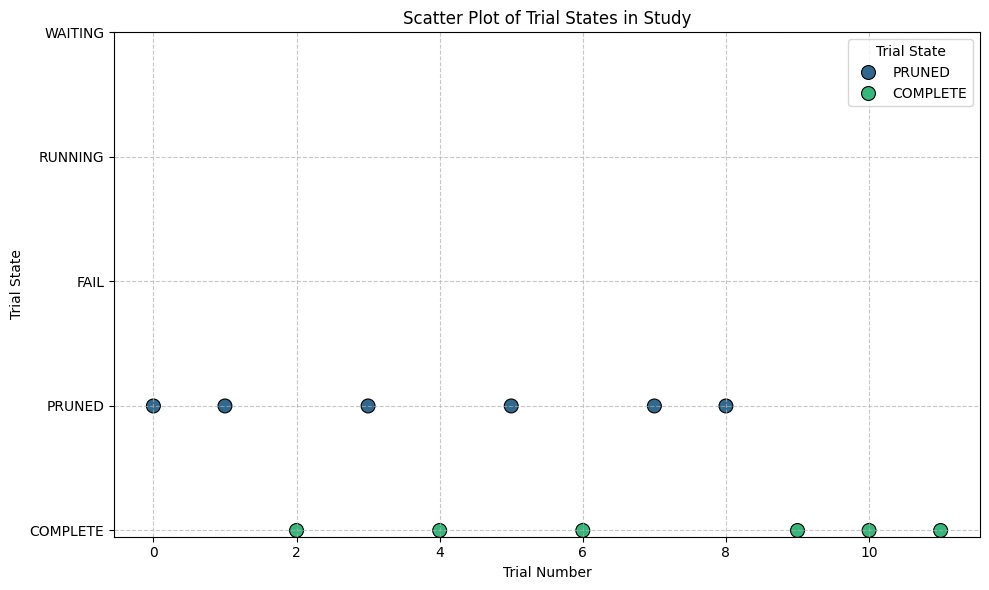

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

# Example data: Map trial states to numeric values
trial_states = [trial.state.name for trial in study.trials]
trial_numbers = range(len(study.trials))
state_mapping = {"COMPLETE": 1, "PRUNED": 2, "FAIL": 3, "RUNNING": 4, "WAITING": 5}
mapped_states = [state_mapping.get(state, 0) for state in trial_states]

# Create a DataFrame for plotting
data = pd.DataFrame({
    "Trial Number": trial_numbers,
    "Mapped State": mapped_states,
    "Trial State": trial_states
})

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=data,
    x="Trial Number",
    y="Mapped State",
    hue="Trial State",  # Add hue for categorical coloring
    palette="viridis",  # Use the Viridis colormap
    s=100,              # Marker size
    edgecolor="k"       # Black edges around markers
)

# Adjust y-axis ticks to display state names
plt.yticks(list(state_mapping.values()), list(state_mapping.keys()))

# Add title, labels, and grid
plt.xlabel("Trial Number")
plt.ylabel("Trial State")
plt.title("Scatter Plot of Trial States in Study")
plt.grid(True, linestyle="--", alpha=0.7)

# Save the plot in SVG format
plot_path_svg = os.path.join(tuning_dir, "trials_state_info_study.svg")
plt.savefig(plot_path_svg, format="svg", bbox_inches="tight")
print(f"Study's trials state info plot saved at: {plot_path_svg}")

# Show the plot
plt.tight_layout()
plt.show()


Study's temporal info plot saved at: executions/swin_unetr/tuning-train-test/id=176/tuning/trial_state_aggregate_count_info_study.svg


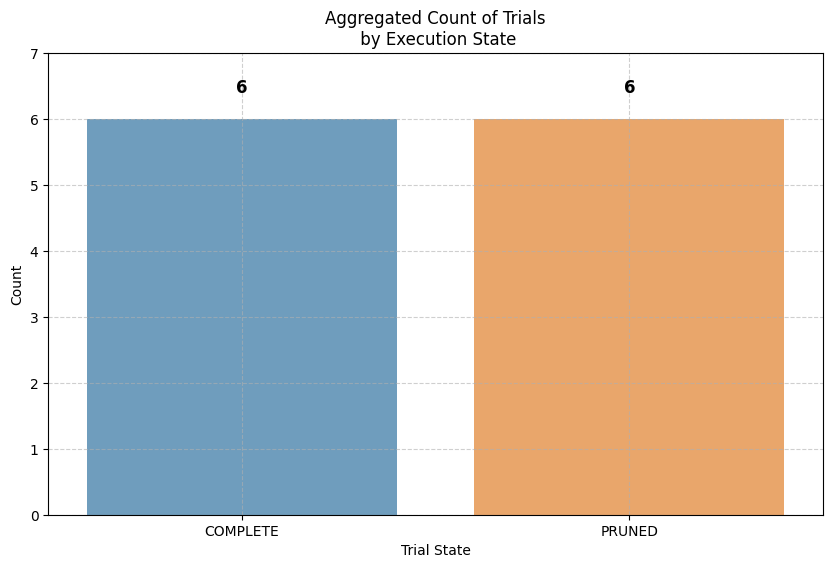

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import os

# Recalculate trial_counts if not already defined
trial_states = [trial.state.name for trial in study.trials]
trial_counts = pd.DataFrame(trial_states, columns=["Trial State"]).value_counts().reset_index()
trial_counts.columns = ["Trial State", "Count"]


# Create the plot with different colors for each state
plt.figure(figsize=(10, 6))
sns.barplot(
    data=trial_counts,
    x="Trial State",
    y="Count",
    hue="Trial State",  # Different colors for each state
    dodge=False,  # Ensure only one bar per state
    alpha=0.7
)

plt.title("Aggregated Count of Trials\n by Execution State")
plt.grid(linestyle="--", alpha=0.6)

# Adjust y-axis limits to make space for annotations
max_count = trial_counts["Count"].max()
plt.ylim(0, max_count + math.ceil(max_count * 0.1))  # Add 10% margin above the tallest bar

# Display values on top of each bar
for index, row in trial_counts.iterrows():
    plt.text(
        index, 
        row["Count"] + 0.4, 
        str(row["Count"]), 
        ha="center", 
        fontsize=12, 
        fontweight="bold"
    )


# Save the plot in vectorial formats (SVG and PDF)
svg_path = os.path.join(tuning_dir, f"trial_state_aggregate_count_info_study.svg")
plt.savefig(svg_path, format="svg", bbox_inches="tight")

print(f"Study's temporal info plot saved at: {svg_path}")

# Show the plot
plt.show()


Total Study Runtime: 0:28:15.988018
Average Trial Duration: 0:02:17.610055
Minimum Trial Duration: 0:00:47.539595
Maximum Trial Duration: 0:04:06.632645
Total Time for PRUNED: 0:06:11.770465
Total Time for COMPLETE: 0:21:19.550192
Study's temporal info plot saved at: executions/swin_unetr/tuning-train-test/id=176/tuning/temporal_info_study.svg


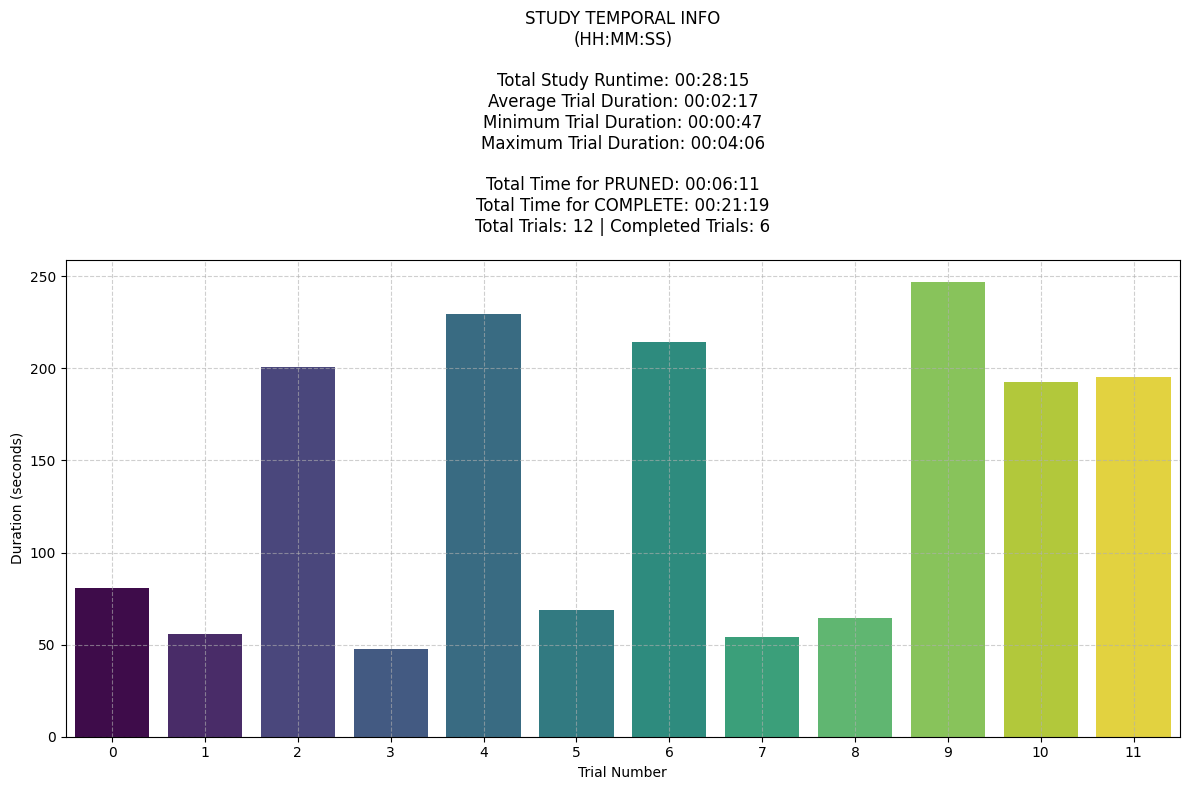

In [18]:
from datetime import timedelta, datetime
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Study-Level Statistics
study_start_time = min(
    (trial.datetime_start for trial in study.trials if trial.datetime_start),
    default=None
)

study_end_time = max(
    (trial.datetime_complete for trial in study.trials if trial.datetime_complete),
    default=datetime.now()
)
total_study_runtime = study_end_time - study_start_time

print(f"Total Study Runtime: {total_study_runtime}")

# Trial-Level Statistics
trial_durations = [
    trial.datetime_complete - trial.datetime_start
    for trial in study.trials
    if trial.datetime_start and trial.datetime_complete
]

if trial_durations:
    avg_duration = sum(trial_durations, timedelta()) / len(trial_durations)
    min_duration = min(trial_durations)
    max_duration = max(trial_durations)

    print(f"Average Trial Duration: {avg_duration}")
    print(f"Minimum Trial Duration: {min_duration}")
    print(f"Maximum Trial Duration: {max_duration}")
else:
    print("No completed trials to calculate durations.")

# Time by Trial State
state_durations = defaultdict(timedelta)
for trial in study.trials:
    if trial.datetime_start and trial.datetime_complete:
        duration = trial.datetime_complete - trial.datetime_start
        state_durations[trial.state] += duration

state_info_str = ""
for state, total_duration in state_durations.items():
    state_info = f"Total Time for {state.name}: {total_duration}"
    print(state_info)
    state_info_str += state_info + "\n"

# Visualize Trial Durations
trial_numbers = [trial.number for trial in study.trials]
trial_durations_in_seconds = [
    (trial.datetime_complete - trial.datetime_start).total_seconds()
    if trial.datetime_complete and trial.datetime_start else 0
    for trial in study.trials
]

# Convert timedelta objects to HH:MM:SS format
def format_timedelta(td):
    total_seconds = int(td.total_seconds())
    hours, remainder = divmod(total_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{hours:02}:{minutes:02}:{seconds:02}"

# Format times
formatted_total_runtime = format_timedelta(total_study_runtime)
formatted_avg_duration = format_timedelta(avg_duration)
formatted_min_duration = format_timedelta(min_duration)
formatted_max_duration = format_timedelta(max_duration)

# Format state-specific durations
state_info_lines = [
    f"Total Time for {state.name}: {format_timedelta(duration)}"
    for state, duration in state_durations.items()
]
state_info_str = "\n".join(state_info_lines)
completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

# Create DataFrame for Seaborn
data = {
    "Trial Number": trial_numbers,
    "Duration (seconds)": trial_durations_in_seconds
}
df = pd.DataFrame(data)

# Plot using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(
    data=df,
    x="Trial Number",
    y="Duration (seconds)",
    hue="Trial Number",  # Use hue to map colors
    dodge=False,  # Prevent multiple bars for each hue
    palette="viridis",  # Apply the color palette
    legend=False        # Hide the legend since it is unnecessary
)

# Add labels and title
plt.xlabel("Trial Number")
plt.ylabel("Duration (seconds)")
title_text = (
    "STUDY TEMPORAL INFO\n(HH:MM:SS)\n\n"
    f"Total Study Runtime: {formatted_total_runtime}\n"
    f"Average Trial Duration: {formatted_avg_duration}\n"
    f"Minimum Trial Duration: {formatted_min_duration}\n"
    f"Maximum Trial Duration: {formatted_max_duration}\n\n"
    f"{state_info_str}\n"
    f"Total Trials: {len(study.trials)} | Completed Trials: {len(completed_trials)}"
)
plt.title(title_text, loc="center", pad=20)
plt.grid(linestyle="--", alpha=0.6)

# Save the plot in SVG format
plot_path_svg = os.path.join(tuning_dir, "temporal_info_study.svg")
plt.savefig(plot_path_svg, format="svg", bbox_inches="tight")
print(f"Study's temporal info plot saved at: {plot_path_svg}")

# Show the plot
plt.tight_layout()
plt.show()

Histogram of trial durations saved at: executions/swin_unetr/tuning-train-test/id=176/tuning/trial_duration_histogram.svg


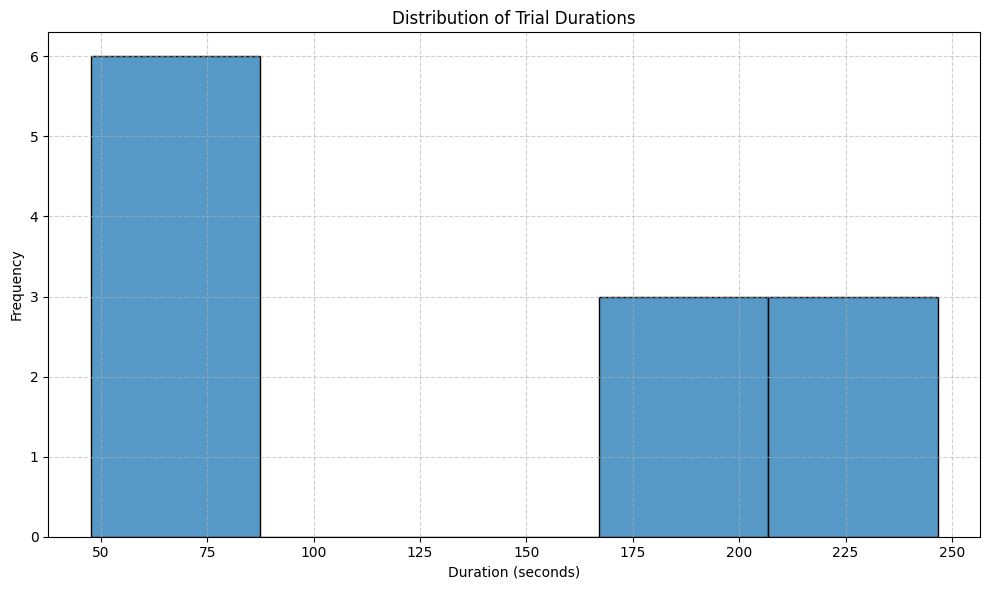

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Create DataFrame for durations
data = {
    "Duration (seconds)": trial_durations_in_seconds
}
df = pd.DataFrame(data)

# Plot histogram using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df,
    x="Duration (seconds)",
)

# Add labels and title
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.title(
    "Distribution of Trial Durations",
    loc="center"
)
plt.grid(linestyle="--", alpha=0.6)

# Save the histogram in SVG format
histogram_path_svg = os.path.join(tuning_dir, "trial_duration_histogram.svg")
plt.savefig(histogram_path_svg, format="svg", bbox_inches="tight")
print(f"Histogram of trial durations saved at: {histogram_path_svg}")

# Show the plot
plt.tight_layout()
plt.show()


Bar plot of CUDA memory usage saved at: executions/swin_unetr/tuning-train-test/id=176/tuning/cuda_memory_usage_info_study.svg


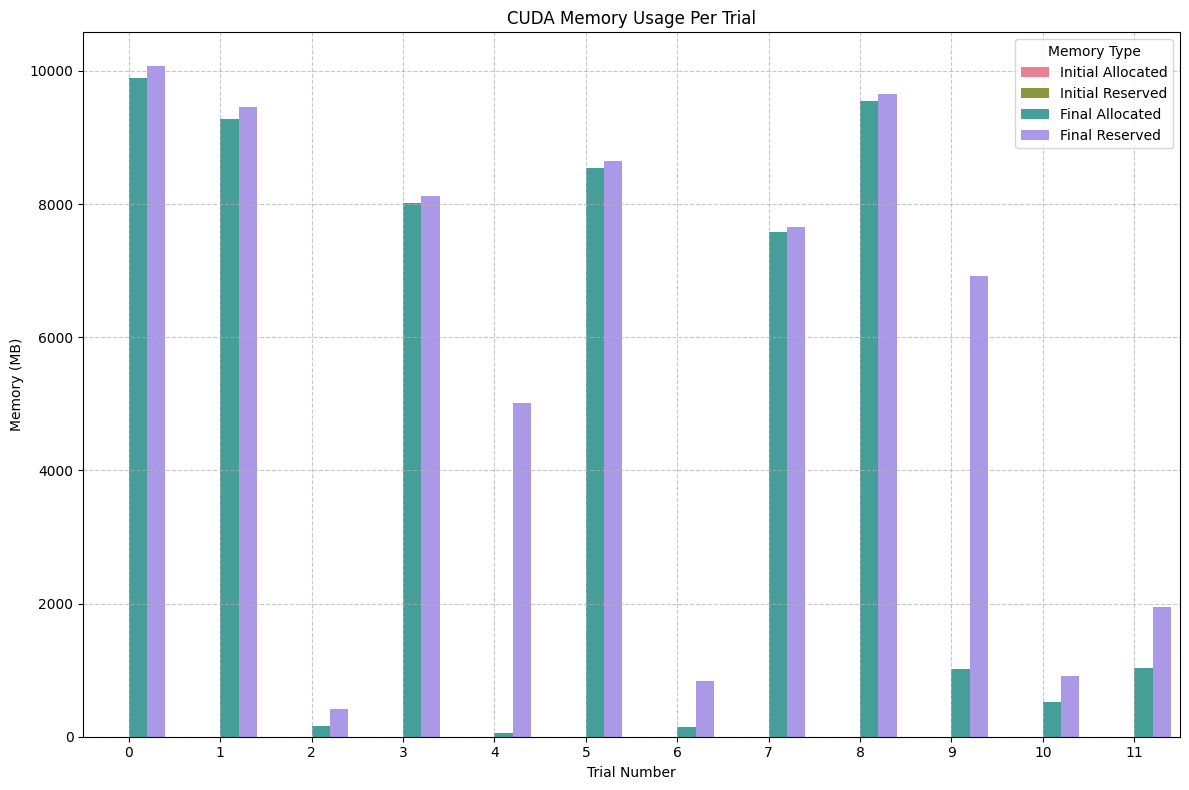

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

# Extract data for plotting
trial_numbers = list(range(0, len(study.trials)))
initial_allocated = [trial.user_attrs["initial_allocated_cuda_memory"] for trial in study.trials if "initial_allocated_cuda_memory" in trial.user_attrs]
initial_reserved = [trial.user_attrs["initial_reserved_cuda_memory"] for trial in study.trials if "initial_reserved_cuda_memory" in trial.user_attrs]
final_allocated = [trial.user_attrs["final_allocated_cuda_memory"] for trial in study.trials if "final_allocated_cuda_memory" in trial.user_attrs]
final_reserved = [trial.user_attrs["final_reserved_cuda_memory"] for trial in study.trials if "final_reserved_cuda_memory" in trial.user_attrs]

# Prepare the data for Seaborn
data = pd.DataFrame({
    "Trial Number": trial_numbers,
    "Initial Allocated": initial_allocated,
    "Initial Reserved": initial_reserved,
    "Final Allocated": final_allocated,
    "Final Reserved": final_reserved,
})

# Melt the data for easier plotting with Seaborn
data_melted = data.melt(id_vars="Trial Number", 
                        var_name="Memory Type", 
                        value_name="Memory (MB)")

# Plot the bar chart using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(
    data=data_melted,
    x="Trial Number",
    y="Memory (MB)",
    hue="Memory Type",
    dodge=True,  # Ensure separate bars for each memory type
    palette="husl"  # Color palette
)

# Add labels and title
plt.xlabel("Trial Number")
plt.ylabel("Memory (MB)")
plt.title("CUDA Memory Usage Per Trial")
plt.legend(title="Memory Type", loc="upper right")
plt.grid(linestyle="--", alpha=0.7)

# Save the plot as an SVG file
plot_path_svg = os.path.join(tuning_dir, f"cuda_memory_usage_info_study.svg")
plt.savefig(plot_path_svg, format="svg", bbox_inches="tight")
print(f"Bar plot of CUDA memory usage saved at: {plot_path_svg}")

# Show the plot
plt.tight_layout()
plt.show()


Histogram for Initial Allocated saved at: executions/swin_unetr/tuning-train-test/id=170/tuning/initial_allocated_memory_usage_histogram.svg


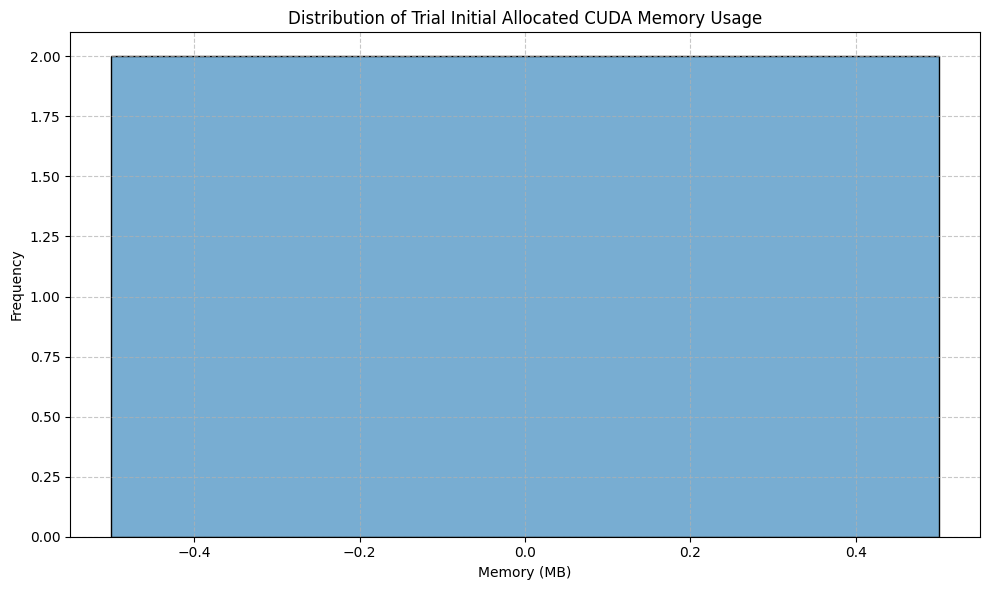

Histogram for Initial Reserved saved at: executions/swin_unetr/tuning-train-test/id=170/tuning/initial_reserved_memory_usage_histogram.svg


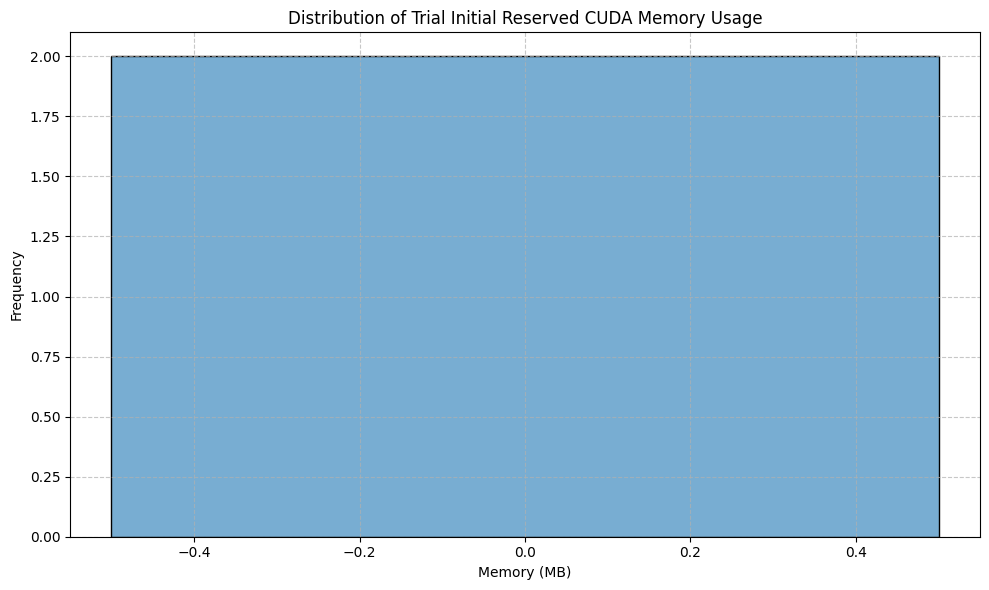

Histogram for Final Allocated saved at: executions/swin_unetr/tuning-train-test/id=170/tuning/final_allocated_memory_usage_histogram.svg


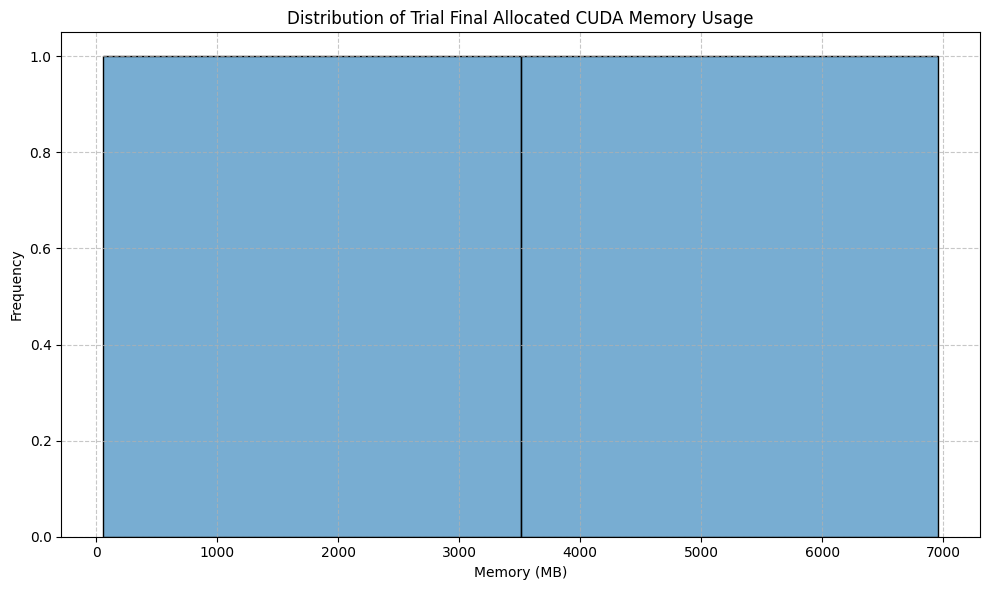

Histogram for Final Reserved saved at: executions/swin_unetr/tuning-train-test/id=170/tuning/final_reserved_memory_usage_histogram.svg


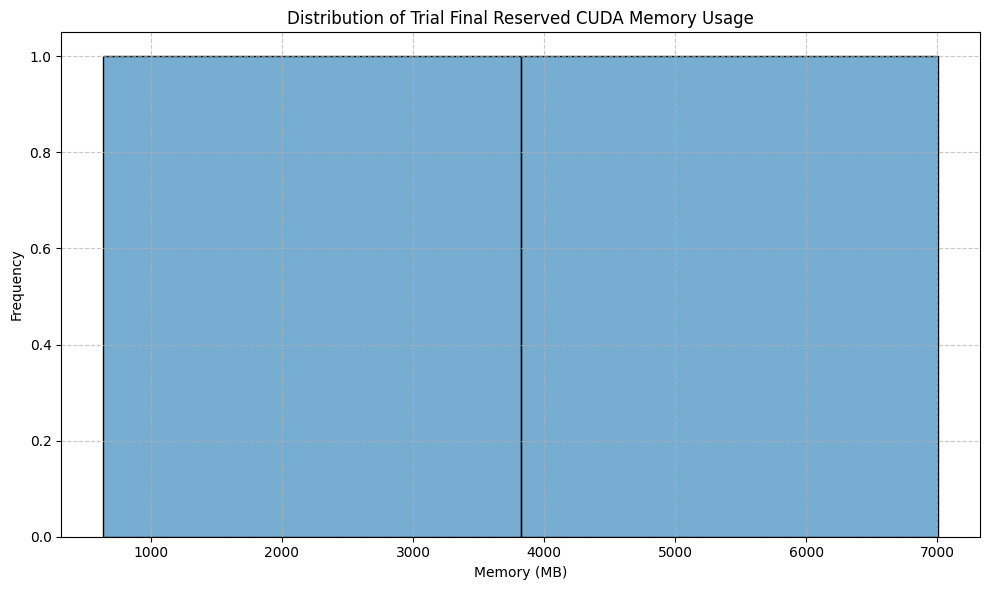

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Extract data for plotting
initial_allocated = [trial.user_attrs["initial_allocated_cuda_memory"] for trial in study.trials if "initial_allocated_cuda_memory" in trial.user_attrs]
initial_reserved = [trial.user_attrs["initial_reserved_cuda_memory"] for trial in study.trials if "initial_reserved_cuda_memory" in trial.user_attrs]
final_allocated = [trial.user_attrs["final_allocated_cuda_memory"] for trial in study.trials if "final_allocated_cuda_memory" in trial.user_attrs]
final_reserved = [trial.user_attrs["final_reserved_cuda_memory"] for trial in study.trials if "final_reserved_cuda_memory" in trial.user_attrs]

# Combine the data into a dictionary for convenience
data = {
    "Initial Allocated": initial_allocated,
    "Initial Reserved": initial_reserved,
    "Final Allocated": final_allocated,
    "Final Reserved": final_reserved
}

# Create separate histograms for each memory type
for label, values in data.items():
    plt.figure(figsize=(10, 6))
    sns.histplot(
        values,
        alpha=0.6
    )
    
    # Add labels and title
    plt.xlabel("Memory (MB)")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of Trial {label} CUDA Memory Usage")
    plt.grid(linestyle="--", alpha=0.7)

    # Save the plot in SVG format
    plot_path_svg = os.path.join(tuning_dir, f"{label.lower().replace(' ', '_')}_memory_usage_histogram.svg")
    plt.savefig(plot_path_svg, format="svg", bbox_inches="tight")
    print(f"Histogram for {label} saved at: {plot_path_svg}")

    # Show the plot
    plt.tight_layout()
    plt.show()


Dual bar plot saved at: executions/swin_unetr/tuning-train-test/id=170/tuning/model_params_flops_study_bar.svg


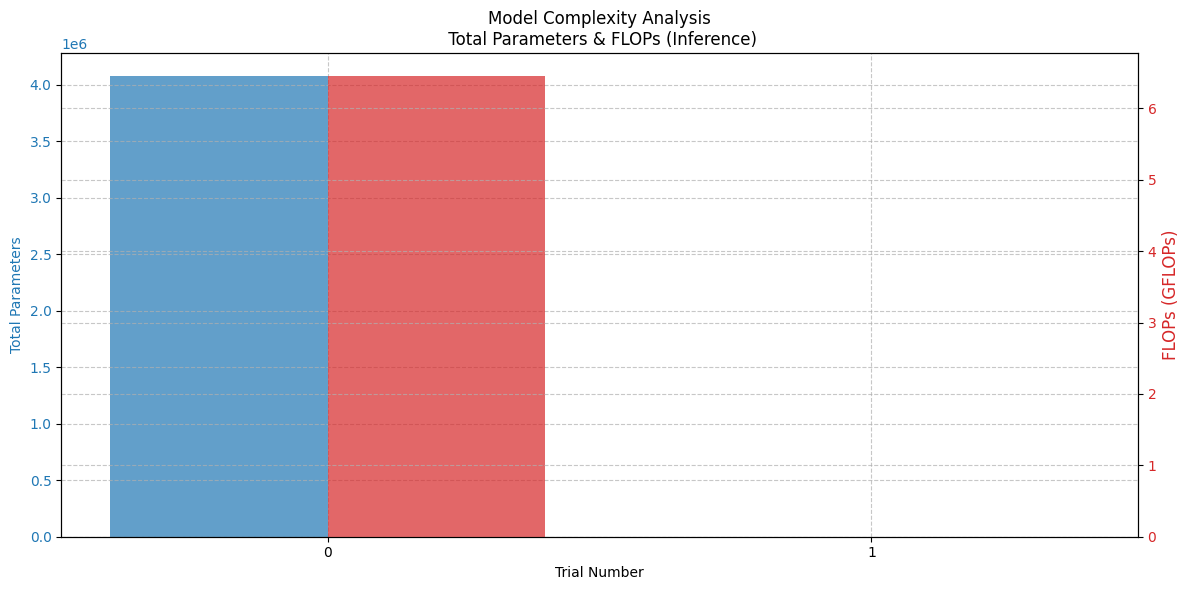

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Extract data for plotting
trial_numbers = list(range(0, len(study.trials)))
total_params = [trial.user_attrs["model_total_params"] for trial in study.trials if "model_total_params" in trial.user_attrs]
flops_inference = [trial.user_attrs["model_gflops_inference"] for trial in study.trials if "model_gflops_inference" in trial.user_attrs]

# Plot the data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar width for better visualization
bar_width = 0.4

# Bar positions
x_indices_params = np.arange(len(total_params))
x_indices_flops = x_indices_params + bar_width

# Plot total parameters as bars
color = 'tab:blue'
ax1.set_xlabel("Trial Number")
ax1.set_ylabel("Total Parameters", color=color)
ax1.bar(x_indices_params, total_params, width=bar_width, label="Total Parameters", color=color, alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(linestyle='--', alpha=0.7)

# Second y-axis for FLOPs
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("FLOPs (GFLOPs)", color=color, fontsize=12)
ax2.bar(x_indices_flops, flops_inference, width=bar_width, label="FLOPs (GFLOPs)", color=color, alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(linestyle='--', alpha=0.7)

# Adjust x-axis ticks to align with bars
ax1.set_xticks(x_indices_params + bar_width / 2)
ax1.set_xticklabels([f"{i}" for i in range(len(total_params))])

# Add title
plt.title("Model Complexity Analysis\n Total Parameters & FLOPs (Inference)")

# Adjust layout for better spacing
fig.tight_layout()

# Save the plot as an SVG file
plot_path_svg = os.path.join(tuning_dir, f"model_params_flops_study_bar.svg")
plt.savefig(plot_path_svg, format="svg", bbox_inches="tight")
print(f"Dual bar plot saved at: {plot_path_svg}")

# Show the plot
plt.show()


# BEST TRIAL

## Summary

In [ ]:
best_trial_model_info = {
    "model_total_params": study.best_trial.user_attrs["model_total_params"],
    "model_trainable_params": study.best_trial.user_attrs["model_trainable_params"],
    "model_non_trainable_params": study.best_trial.user_attrs["model_non_trainable_params"],
    "model_gflops_inference": study.best_trial.user_attrs["model_gflops_inference"] # IN GFLOPS
}

best_trial_overlap_training = study.best_trial.params["overlap_training"]
best_trial_overlap_training = (best_trial_overlap_training, best_trial_overlap_training)

best_trial_training_config={
    "lr_optimizer": study.best_trial.params["lr_optimizer"],
    "weight_decay_optimizer": study.best_trial.params["weight_decay_optimizer"],
    "warmup_epochs_lr_scheduler": study.best_trial.params["warmup_epochs_lr_scheduler"],
    "max_training_epochs": study.best_trial.params["max_training_epochs"],
    "patience_epochs_early_stopping": study.best_trial.params["patience_epochs_early_stopping"],
    "batch_size_training": study.best_trial.params["batch_size_training"],
    "batch_size_inference": study.best_trial.params["batch_size_inference"],
    "num_batches_grad_accumulation": study.best_trial.params["num_batches_grad_accumulation"],
    "overlap_training": best_trial_overlap_training,
    "overlap_inference": eval(study.best_trial.params["overlap_inference"]),
    "post_processing_strategy": study.best_trial.params["post_processing_strategy"],
    "pre_processing_strategy": study.best_trial.params["pre_processing_strategy"]
}
# Architecture
best_trial_model_spatial_input_dim = study.best_trial.params["model_spatial_input_dims"]
best_trial_exponent_model_temporal_input_dim = study.best_trial.params["exponent_model_temporal_input_dim"]
best_trial_model_temporal_input_dim = 64*(2**best_trial_exponent_model_temporal_input_dim)
best_trial_model_input_dimensions = (best_trial_model_spatial_input_dim, best_trial_model_spatial_input_dim) + (best_trial_model_temporal_input_dim,)
best_trial_initial_feature_embedding_size = 12*(2**study.best_trial.params["exponent_initial_feature_embedding_size"])

# Architecture Configuration
best_trial_architecture_config={
    "use_SWIN_v2": study.best_trial.params["use_SWIN_v2"],
    "model_input_dimensions": best_trial_model_input_dimensions,
    "model_input_channels": 1,
    "model_output_channels": 2, # 2 output channels = 2 output classes (i.e. defective/non-defective)
    "initial_feature_embedding_size": best_trial_initial_feature_embedding_size,
    "patch_embedding_size": (study.best_trial.params["patch_embedding_size"], study.best_trial.params["patch_embedding_size"], study.best_trial.params["patch_embedding_size"]),
    "num_swin_transformer_blocks_in_layers": (study.best_trial.params["num_swin_transformer_blocks_in_layers"], study.best_trial.params["num_swin_transformer_blocks_in_layers"], study.best_trial.params["num_swin_transformer_blocks_in_layers"], study.best_trial.params["num_swin_transformer_blocks_in_layers"]),
    "mlp_ratio": study.best_trial.params["mlp_ratio"],
}

best_trial_initial_attention_head = study.best_trial.params["initial_attention_head"]
best_trial_attention_heads = (best_trial_initial_attention_head, best_trial_initial_attention_head*2, best_trial_initial_attention_head*4, best_trial_initial_attention_head*8)

# Attention Configuration
best_trial_attention_config={
    "heads": best_trial_attention_heads,
    "window_size": (study.best_trial.params["attention_window_size"], study.best_trial.params["attention_window_size"], study.best_trial.params["attention_window_size"]),
    "qkv_bias": study.best_trial.params["attention_qkv_projections_bias"],
    "drop_rate": study.best_trial.params["attention_weights_drop_rate"]
}

# Normalization Configuration
best_trial_normalization_config={
    "use_norm_in_swinViT_after_layer": study.best_trial.params["layer_normalization_after_each_layer_in_SWIN_Transformer"],
    "patch_norm_in_swinViT": study.best_trial.params["normalization_after_patch_embedding"],
    "unet_block_norm_type": study.best_trial.params["type_normalization_in_UNET_block"]
}

# Regularization Configuration
best_trial_regularization_config={
    "transformer_block_drop_rate": study.best_trial.params["transformer_block_drop_rate"],
    "transformer_block_residual_block_dropout_path_rate": study.best_trial.params["transformer_block_residual_block_dropout_path_rate"],
}

# Combine all configs into a single dictionary
best_trial_config = {
    "TRIAL_ID": study.best_trial.number,
    "VAL_LOSS": study.best_trial.value,
    "MODEL_INFO": best_trial_model_info,
    "TRAINING_CONFIG": best_trial_training_config,
    "ARCHITECTURE_CONFIG": best_trial_architecture_config,
    "ATTENTION_CONFIG": best_trial_attention_config,
    "NORMALIZATION_CONFIG": best_trial_normalization_config,
    "REGULARIZATION_CONFIG": best_trial_regularization_config
}

# Generate JSON with best trial's hyperparameter config
info_best_trial_json_file_path = os.path.join(tuning_dir, "best_trial", "best_trial_summary_info.json")
with open(info_best_trial_json_file_path, "w") as json_file:
    json.dump(best_trial_config, json_file, indent=4)
print(f"Best trial config JSON file successfully generated at: {info_best_trial_json_file_path}")

print()
print(f"{'=' * 50}")
print(f"{'=' * 18} BEST TRIAL: {study.best_trial.number} {'=' * 17}")
print(f"{'=' * 16} Val. Loss: {study.best_trial.value:.4f} {'=' * 16}")
print(f"{'=' * 50}")
print()

print(f"Total Parameters: {study.best_trial.user_attrs['model_total_params']}")
print(f"Trainable Parameters: {study.best_trial.user_attrs['model_trainable_params']}")
print(f"Non-Trainable Parameters: {study.best_trial.user_attrs['model_non_trainable_params']}")
print(f"FLOPs: {study.best_trial.user_attrs['model_gflops_inference'] :.3f} GFLOPs")

print()
print()

# Pretty-print the configurations
pprint.pprint(best_trial_config, sort_dicts=False, width=100)

print()

## Validation Results (Ground Truth vs Prediction)

In [ ]:
from IPython.display import SVG

svg_file = os.path.join(tuning_dir, "best_trial", f"validation_gt_vs_pred.svg")
# Display the SVG file
SVG(svg_file)  # Replace with your SVG file path

## Training vs Validation Loss Evolution

In [ ]:
from IPython.display import SVG

svg_file = os.path.join(tuning_dir, "best_trial", f"train_val_loss_evolution.svg")
# Display the SVG file
SVG(svg_file)  # Replace with your SVG file path